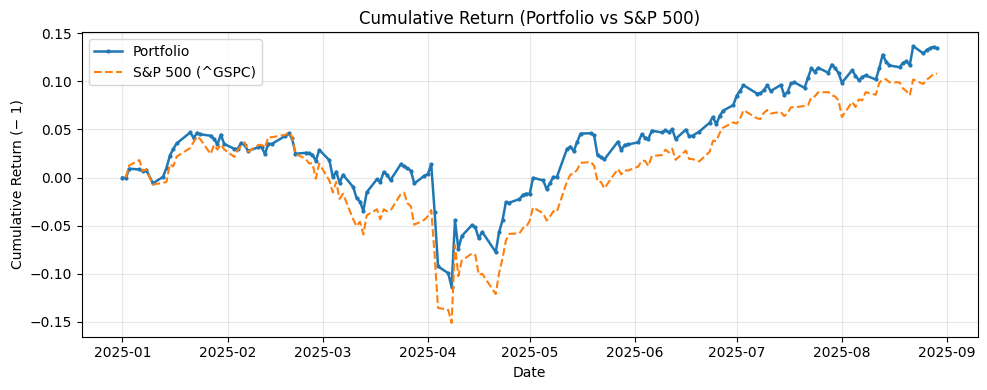

,date,net_liquidation
161,2025-08-25,1.128987e+06
162,2025-08-26,1.132712e+06
163,2025-08-27,1.134426e+06
164,2025-08-28,1.135879e+06
165,2025-08-29,1.134348e+06


In [1]:
import os, json, re
from datetime import datetime, timedelta
import pandas as pd
import matplotlib.pyplot as plt

root = os.getcwd()
date_re = re.compile(r'^\d{4}-\d{2}-\d{2}$')

rows = []
for name in sorted(os.listdir(root)):
    if date_re.match(name):
        snap_path = os.path.join(root, name, f'portfolio_snapshot_{name}.json')
        if os.path.exists(snap_path):
            try:
                with open(snap_path, 'r') as f:
                    snap = json.load(f)
                net_liq = snap.get('net_liquidation', snap.get('portfolio_value'))
                rows.append({'date': name, 'net_liquidation': float(net_liq)})
            except Exception:
                pass

if not rows:
    print('No snapshots found.')
else:
    df = pd.DataFrame(rows)
    df['date'] = pd.to_datetime(df['date'])
    df = df.sort_values('date').reset_index(drop=True)

    # Cumulative return vs S&P 500 (difference from 1)
    results_dir = os.path.join(root, 'results')
    os.makedirs(results_dir, exist_ok=True)

    # Portfolio cumulative return
    p_cum = df['net_liquidation'] / df['net_liquidation'].iloc[0]

    # Fetch S&P 500 from local CSV sp500_closing_prices.csv
    spx_cum = None
    csv_path = os.path.join(root, 'sp500_closing_prices.csv')
    if os.path.exists(csv_path):
        try:
            spx_df = pd.read_csv(csv_path, header=None, skiprows=3, names=['Date','Close'])
            spx_df = spx_df.dropna()
            spx_df['Date'] = pd.to_datetime(spx_df['Date'])
            spx_df = spx_df.sort_values('Date')
            spx_close = spx_df.set_index('Date')['Close']
            # align to portfolio dates
            spx_aligned = spx_close.reindex(df['date'], method='ffill')
            if spx_aligned.notna().any():
                spx_cum = spx_aligned / spx_aligned.dropna().iloc[0]
        except Exception as e:
            print('Failed to read sp500_closing_prices.csv:', e)

    plt.figure(figsize=(10, 4))
    plt.plot(df['date'], p_cum - 1.0, label='Portfolio', linewidth=1.8, marker='o', markersize=2)
    if spx_cum is not None:
        plt.plot(df['date'], spx_cum - 1.0, label='S&P 500 (^GSPC)', linestyle='--', linewidth=1.5)
    plt.title('Cumulative Return (Portfolio vs S&P 500)')
    plt.xlabel('Date')
    plt.ylabel('Cumulative Return (− 1)')
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    out_path = os.path.join(results_dir, 'cumulative_return.png')
    plt.savefig(out_path, dpi=150)
    plt.show()

    display(df.tail())


In [2]:
# Top gainers/losers across the whole portfolio (based on last vs entry price)
import math

changes = []
for name in sorted(os.listdir(root)):
    if date_re.match(name):
        snap_path = os.path.join(root, name, f'portfolio_snapshot_{name}.json')
        if not os.path.exists(snap_path):
            continue
        with open(snap_path, 'r') as f:
            snap = json.load(f)
        port = snap.get('portfolio', {})
        for t, info in port.items():
            qty = float(info.get('totalAmount', 0))
            if qty <= 0:
                continue
            last_p = float(info.get('last_price', 0))
            entry_p = float(info.get('entry_price', 0)) or last_p
            if entry_p <= 0:
                continue
            ret = (last_p / entry_p) - 1.0
            changes.append({'date': name, 'ticker': t, 'qty': qty, 'entry': entry_p, 'last': last_p, 'return': ret})

if not changes:
    print('No positions found with positive quantity.')
else:
    chdf = pd.DataFrame(changes)
    # Take last observation per ticker (latest date)
    chdf['date_dt'] = pd.to_datetime(chdf['date'])
    idx = chdf.sort_values(['ticker','date_dt']).groupby('ticker').tail(1).index
    latest = chdf.loc[idx].reset_index(drop=True)

    top_gainers = latest.sort_values('return', ascending=False).head(20)
    top_losers  = latest.sort_values('return', ascending=True).head(20)

    display(top_gainers[['ticker','return','entry','last','qty']])
    display(top_losers[['ticker','return','entry','last','qty']])


,ticker,return,entry,last,qty
242,NEM,0.973028,37.708546,74.400002,103.0
248,NRG,0.586680,91.738747,145.559998,47.0
29,APH,0.559703,69.795334,108.860001,69.0
177,IDXX,0.557264,415.529999,647.090027,13.0
319,TEL,0.486163,138.948441,206.500000,2.0
100,DG,0.484967,73.240685,108.760002,54.0
334,UBER,0.463691,64.050397,93.750000,50.0
155,GLW,0.395588,48.029929,67.029999,870.0
261,PARA,0.389455,10.579685,14.700000,505.0
190,JBL,0.370442,149.462677,204.830002,8.0


,ticker,return,entry,last,qty
75,CNC,-0.527651,61.480000,29.040001,24.0
124,ENPH,-0.471693,71.360001,37.700001,14.0
99,DECK,-0.422774,207.250000,119.629997,10.0
229,MOH,-0.385955,294.489990,180.830002,7.0
337,UNH,-0.385262,504.068451,309.869995,8.0
73,CMG,-0.296377,59.889999,42.139999,6.0
56,CAG,-0.275866,26.417749,19.129999,85.0
72,CLX,-0.264483,160.703234,118.199997,29.0
339,UPS,-0.258470,117.918419,87.440002,18.0
256,OKE,-0.257726,102.900000,76.379997,31.0


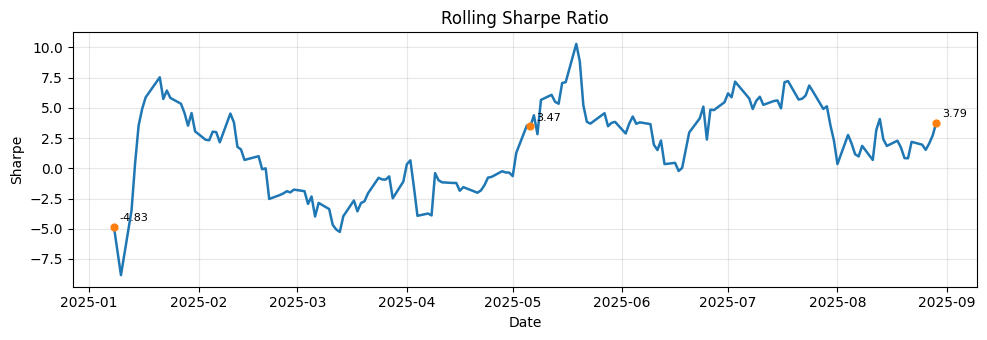

Saved: /Users/blakealmon/Documents/Code/GitHub/ABMR-TradingAgents/testing/results/rolling_sharpe.png


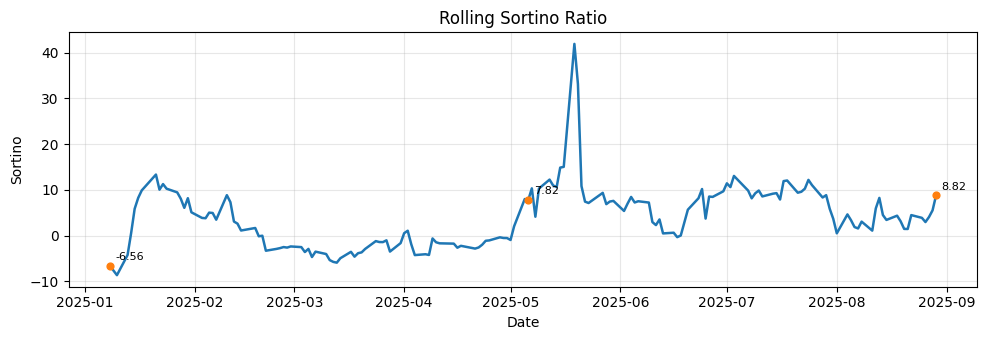

Saved: /Users/blakealmon/Documents/Code/GitHub/ABMR-TradingAgents/testing/results/rolling_sortino.png


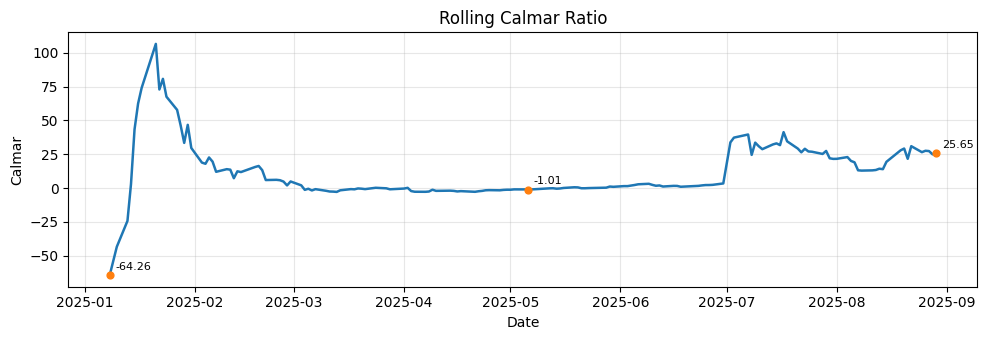

Saved: /Users/blakealmon/Documents/Code/GitHub/ABMR-TradingAgents/testing/results/rolling_calmar.png


In [3]:
import os, json
import pandas as pd
import matplotlib.pyplot as plt

# Save rolling Sharpe/Sortino/Calmar charts to results/
results_dir = os.path.join(root, 'results')
os.makedirs(results_dir, exist_ok=True)

metrics_path = os.path.join(results_dir, 'rolling_metrics.json')
if not os.path.exists(metrics_path):
    print('rolling_metrics.json not found:', metrics_path)
else:
    with open(metrics_path, 'r') as f:
        data = json.load(f)
    dates = pd.to_datetime(pd.Series(data.get('dates', [])))
    sharpe = pd.to_numeric(pd.Series(data.get('sharpe', [])), errors='coerce')
    sortino = pd.to_numeric(pd.Series(data.get('sortino', [])), errors='coerce')
    calmar = pd.to_numeric(pd.Series(data.get('calmar', [])), errors='coerce')

    charts = [
        ('rolling_sharpe.png', sharpe, 'Rolling Sharpe Ratio', 'Sharpe'),
        ('rolling_sortino.png', sortino, 'Rolling Sortino Ratio', 'Sortino'),
        ('rolling_calmar.png', calmar, 'Rolling Calmar Ratio', 'Calmar'),
    ]

    # Trim first two points to avoid initial jump and add markers
    import numpy as np
    dates_t = dates.iloc[2:]
    for filename, series, title, ylabel in charts:
        s_t = series.iloc[2:]
        plt.figure(figsize=(10, 3.5))
        plt.plot(dates_t, s_t, linewidth=1.8)
        # pick 2-3 representative points and annotate their values
        dfm = pd.DataFrame({"date": dates_t, "value": s_t}).dropna().reset_index(drop=True)
        if len(dfm) > 0:
            k = 3 if len(dfm) >= 3 else len(dfm)
            sel_idx = np.unique(np.linspace(0, len(dfm) - 1, k, dtype=int))
            pts = dfm.iloc[sel_idx]
            plt.scatter(pts['date'], pts['value'], color='C1', s=24, zorder=3)
            for _, row in pts.iterrows():
                plt.annotate(f"{row['value']:.2f}", (row['date'], row['value']), textcoords="offset points", xytext=(4,4), fontsize=8)
        plt.title(title)
        plt.xlabel('Date')
        plt.ylabel(ylabel)
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        out_path = os.path.join(results_dir, filename)
        plt.savefig(out_path, dpi=150)
        plt.show()
        print('Saved:', out_path)
        plt.close()

